In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from db_queries import get_outputs, get_ids, get_age_metadata

from vivarium_inputs import get_raw_data, get_population_structure, get_demographic_dimensions
from vivarium_inputs.core import get_data
from vivarium_inputs.globals import Population
from vivarium_inputs.utilities import scrub_gbd_conventions
from gbd_mapping import causes, risk_factors

In [2]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Legend
from bokeh.layouts import row, column
output_notebook()

Loading BokehJS ...

In [3]:
# Important to note this is a baseline run, no interventions.
# COUNTRIES = ['India']
RESULTS_DIRECTORIES = {'India': Path("/share/costeffectiveness/results/vivarium_conic_sam_comparison/"
                                     "vivarium_conic_sam_comparison_India/2019_09_08_23_08_54")}
COUNTRIES = list(RESULTS_DIRECTORIES.keys())
CAUSES = [causes.diarrheal_diseases, causes.lower_respiratory_infections, 
          causes.measles, causes.protein_energy_malnutrition, 
          causes.neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,
          causes.neonatal_sepsis_and_other_neonatal_infections, 
          causes.hemolytic_disease_and_other_neonatal_jaundice]

In [4]:
# results = pd.read_hdf(RESULTS_DIRECTORIES['India'] / "output.hdf")

## Sim runtimes in hours

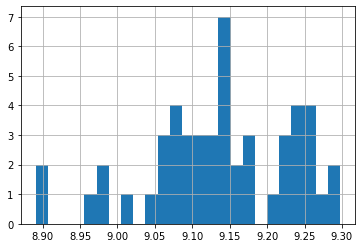

In [5]:
# TODO: Add titles etc, switch to Bokeh

for country, results_dir in RESULTS_DIRECTORIES.items():
    results = pd.read_hdf(results_dir / "output.hdf")
    (results['simulation_run_time'] / 3600.).hist(bins=25)
    plt.show()

## The GBD ID dance

In [7]:
## use get_ids to figure out the stuff I want
gbd_measure_ids = get_ids("measure")
gbd_metric_ids = get_ids("metric")
gbd_age_group_set_ids = get_ids("age_group_set")
gbd_2015_age_group_set = 1
gbd_age_group_ids = get_ids("age_group")
gbd_age_group_metadata = get_age_metadata(age_group_set_id=1, gbd_round_id=5)
gbd_sex_ids = get_ids("sex")
gbd_location_ids = get_ids("location")

# sets of IDS we are interested in for requesting stuff from get_outputs
LOCATION_IDS = dict(zip(location_ids['location_name'], location_ids['location_id']))
FULL_AGE_ID_SET = dict(zip(age_group_ids['age_group_id'], age_group_ids['age_group_name']))
AGE_IDS = {FULL_AGE_ID_SET[age_id]: age_id for age_id in age_group_metadata['age_group_id'].unique()}
SEX_IDS = {
    'Male': 1,
    'Female': 2
}
MEASURE_IDS = {
    'Deaths': 1,
    'DALYs': 2,
    'YLDs': 3,
    'YLLs': 4,
#     'CSMR': 15  # TODO: Why broken ?
}
METRIC_IDS = {
    'rate': 3
}

KeyboardInterrupt: 

In [ ]:
get_outputs("cause", cause_id=CAUSES[0].gbd_id, gbd_round_id=5)

In [ ]:
def get_gbd_data(location, cause, measure):
    df = get_outputs("cause", 
                    cause_id=cause.gbd_id, 
                    metric_id=[METRIC_IDS['rate']], 
                    measure_id=[MEASURE_IDS[measure]], 
                    year_id=[2017],
                    location_id=[LOCATION_IDS[location]],
                    age_group_id=list(AGE_IDS.values()),
                    sex_id=list(SEX_IDS.values()),
                    gbd_round_id=5)
    df = df.set_index(['location_name', 'age_group_name', 'cause_name', 'sex', 'measure_name'])
    df = df[['lower', 'val', 'upper']]
    df = df.reset_index()
    
    return df

In [ ]:
def plot_comparison(df, location, cause, measure):   
    male = df.loc[df.sex == 'Male']
    female = df.loc[df.sex == 'Female']

    male_subplot = figure(title=f"{measure} for {cause} in Males in {location}", 
                          x_range=male.age_group_name.unique(), plot_width=900)
    male_subplot.xaxis.major_label_orientation = -20  # should use Pi but who cares :'D
    male_subplot.xaxis.axis_label = 'Age Groups'
    male_subplot.xaxis.axis_label_text_font_size = "28pt"
    male_line = male_subplot.line(male.age_group_name, male.val)
    male_ui = male_subplot.varea(male.age_group_name, male.lower, male.upper, fill_alpha=0.1)
    
    male_legend = Legend()

    female_subplot = figure(title=f"{measure} for {cause} in Females in {location}", 
                            x_range=male.age_group_name.unique(), plot_width=900)
    female_subplot.xaxis.major_label_orientation = -20  # should use Pi but who cares :'D
    female_subplot.xaxis.axis_label = 'Age Groups'
    female_subplot.xaxis.axis_label_text_font_size = "28pt"
    female_line = female_subplot.line(female.age_group_name, female.val, line_color='pink')
    female_ui = female_subplot.varea(female.age_group_name, female.lower, female.upper, fill_alpha=0.1, fill_color='pink')
    
    show(column(male_subplot, female_subplot))

In [ ]:
for country, _ in RESULTS_DIRECTORIES.items():
    for cause in CAUSES:
        for mid in MEASURE_IDS.keys():
#             print(f"Pulling data for {country} {cause.name} {mid}")
            data = get_gbd_data(country, cause, mid)
            plot_comparison(data, country, cause.name, mid)

## Get simulation results

In [550]:
# Functions for getting measures from sam results stratified only by WHZ
# TODO: need to calculate UI and reshape so that sex and age is long

def get_deaths_due_to(cause, sim_results):
    death_columns = [c for c in sim_results.columns if f"death_due_to_{cause.name}" in c]
    total_deaths_due_to_cause = sim_results[death_columns].sum(axis=1).groupby('input_draw_number').sum(axis=0)
    return total_deaths_due_to_cause


def get_person_time(sim_results):
    pt_columns = [c for c in sim_results.columns if "person_time" in c]
    total_person_time = sim_results[pt_columns].sum(axis=1).groupby('input_draw_number').sum(axis=0)
    return total_person_time


def get_csmr(cause, sim_results):
    deaths = get_deaths_due_to(cause, sim_results)
    pt = get_person_time(sim_results)
    return deaths / pt


def get_years_lived(kind, sim_results):
    columns = [c for c in sim_results.columns if f"{kind}_due_to_{cause.name}" in c]
    total_due_to_cause = sim_results[columns].sum(axis=1).groupby('input_draw_number').sum(axis=0)
    return total_due_to_cause


def get_years_lived_rate(kind, sim_results):
    years_lived = get_years_lived(kind, sim_results)
    pt = get_person_time(sim_results)
    return years_lived / pt


SyntaxError: invalid syntax (<ipython-input-550-3d0a747657b6>, line 33)

In [551]:
for c in CAUSES:
    print(c.name)
    print(get_csmr(c, results))

diarrheal_diseases
input_draw_number
29.0     0.000603
232.0    0.000649
357.0    0.000606
394.0    0.000535
602.0    0.000771
629.0    0.000986
650.0    0.000954
680.0    0.000870
829.0    0.000667
946.0    0.000894
dtype: float64
lower_respiratory_infections
input_draw_number
29.0     0.000285
232.0    0.000341
357.0    0.000314
394.0    0.000328
602.0    0.000337
629.0    0.000269
650.0    0.000273
680.0    0.000260
829.0    0.000298
946.0    0.000314
dtype: float64
measles
input_draw_number
29.0     0.000003
232.0    0.000003
357.0    0.000006
394.0    0.000023
602.0    0.000016
629.0    0.000023
650.0    0.000000
680.0    0.000000
829.0    0.000006
946.0    0.000010
dtype: float64
protein_energy_malnutrition
input_draw_number
29.0     0.000716
232.0    0.000847
357.0    0.000693
394.0    0.000678
602.0    0.000664
629.0    0.000717
650.0    0.000841
680.0    0.000877
829.0    0.000758
946.0    0.000813
dtype: float64
neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma
input_d